In [633]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
    
# tf.config.experimental.set_visible_devices([], 'GPU')
# tf.debugging.set_log_device_placement(True)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [682]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [693]:
import pandas as pd
import numpy as np

# Load data
prefix = 'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/weather/jobs/transform_batch/20220925-014051_e32aa567fa482e970513332d1d24fd51'

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

# Parameters
condition_window = 24
prediction_window = 24
features_length = 9 # Updated to include the new features

test_size = 81600

new_val_X = train_X.iloc[-test_size:]
new_val_y = train_y.iloc[-test_size:]

# Remove the last 10% from train_X and train_y
train_X = train_X.iloc[:-test_size]
train_y = train_y.iloc[:-test_size]

# Combine current test and validation sets to form the new validation set
new_validate_X = pd.concat([validate_X,test_X], axis=0)
new_validate_y = pd.concat([validate_y,test_y], axis=0)

test_X = new_validate_X
test_y = new_validate_y
validate_X=new_val_X
validate_y=new_val_y
# Manual dictionary with city coordinates
# Recreate the manual dictionary with additional missing cities included
manual_city_coordinates = {
    'Albuquerque': (35.0844, -106.6504),
    'Atlanta': (33.7490, -84.3880),
    'Boston': (42.3601, -71.0589),
    'Charlotte': (35.2271, -80.8431),
    'Chicago': (41.8781, -87.6298),
    'Dallas': (32.7767, -96.7970),
    'Denver': (39.7392, -104.9903),
    'Detroit': (42.3314, -83.0458),
    'Eilat': (29.5577, 34.9519),
    'Haifa': (32.7940, 34.9896),
    'Houston': (29.7604, -95.3698),
    'Indianapolis': (39.7684, -86.1581),
    'Jacksonville': (30.3322, -81.6557),
    'Jerusalem': (31.7683, 35.2137),
    'Kansas City': (39.0997, -94.5786),
    'Las Vegas': (36.1699, -115.1398),
    'Los Angeles': (34.0522, -118.2437),
    'Miami': (25.7617, -80.1918),
    'Minneapolis': (44.9778, -93.2650),
    'Montreal': (45.5017, -73.5673),
    'Nahariyya': (33.0061, 35.0944),
    'Nashville': (36.1627, -86.7816),
    'New York': (40.7128, -74.0060),
    'Philadelphia': (39.9526, -75.1652),
    'Phoenix': (33.4484, -112.0740),
    'Pittsburgh': (40.4406, -79.9959),
    'Portland': (45.5122, -122.6587),
    'Saint Louis': (38.6270, -90.1994),
    'San Antonio': (29.4241, -98.4936),
    'San Diego': (32.7157, -117.1611),
    'San Francisco': (37.7749, -122.4194),
    'Seattle': (47.6062, -122.3321),
    'Tel Aviv District': (32.0853, 34.7818),
    'Toronto': (43.6532, -79.3832),
    'Vancouver': (49.2827, -123.1207)
}

# Updated function to add lat/long based on city names
def extract_features_with_updated_coordinates(df_X):
    # Extract City from the 'sample' column
    df_X['city'] = df_X.index.get_level_values('sample').str.split('/').str[0]

    # Convert 'time' column to datetime
    df_X['times'] = pd.to_datetime(df_X.index.get_level_values('time'))

    # Extract month, day, hour, and time of day
    df_X['month'] = df_X['times'].dt.month
    df_X['day'] = df_X['times'].dt.day
    df_X['hour'] = df_X['times'].dt.hour

    # Map city to its latitude and longitude
    df_X['latitude'] = df_X['city'].map(lambda city: manual_city_coordinates.get(city, (None, None))[0])
    df_X['longitude'] = df_X['city'].map(lambda city: manual_city_coordinates.get(city, (None, None))[1])
    
    return df_X


# Helper function to extract features and add lat/long
def extract_features_with_coordinates(df_X):
    # Extract City from the 'sample' column
    df_X['city'] = df_X.index.get_level_values('sample').str.split('/').str[0]

    # Convert 'time' column to datetime
    df_X['times'] = pd.to_datetime(df_X.index.get_level_values('time'))

    # Extract month, day, hour, and time of day
    df_X['month'] = df_X['times'].dt.month
    df_X['day'] = df_X['times'].dt.day
    df_X['hour'] = df_X['times'].dt.hour

    # Map city to its latitude and longitude
    df_X['latitude'] = df_X['city'].map(lambda city: manual_city_coordinates.get(city, (None, None))[0])
    df_X['longitude'] = df_X['city'].map(lambda city: manual_city_coordinates.get(city, (None, None))[1])
    
    return df_X

# Apply the function to all datasets
train_X = extract_features_with_coordinates(train_X)
validate_X = extract_features_with_coordinates(validate_X)
test_X = extract_features_with_coordinates(test_X)
score_X = extract_features_with_coordinates(score_X)
train_y = extract_features_with_coordinates(train_y)
validate_y = extract_features_with_coordinates(validate_y)
test_y = extract_features_with_coordinates(test_y)

# Confirm new shapes and check the newly added features
print("Train X shape:", train_X.shape)
print("Train y shape:", train_y.shape)
print("Validation X shape:", validate_X.shape)
print("Validation y shape:", validate_y.shape)
print("Test X shape:", test_X.shape)
print("Test y shape:", test_y.shape)

Train X shape: (744864, 11)
Train y shape: (744864, 11)
Validation X shape: (81600, 11)
Validation y shape: (81600, 11)
Test X shape: (107160, 11)
Test y shape: (107160, 11)


In [694]:
# Drop the 'time' and 'time_of_day' columns from the train dataset
train_X = train_X.drop(columns=['times','city'])
validate_X = validate_X.drop(columns=['times','city'])
test_X = test_X.drop(columns=['times','city'])
score_X = score_X.drop(columns=['times','city'])
test_y =  test_y.drop(columns=['times','city'])
train_y=  train_y.drop(columns=['times','city'])
validate_y= validate_y.drop(columns=['times','city'])
# Confirm the shape after dropping the columns
  # Check to make sure the columns were dropped


In [695]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 744864 entries, ('Albuquerque/1108/0', Timestamp('2015-02-16 09:00:00')) to ('Seattle/2248/1', Timestamp('2016-07-27 04:00:00'))
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  744864 non-null  float64
 1   humidity     744864 non-null  float64
 2   pressure     744864 non-null  float64
 3   wind_speed   744864 non-null  float64
 4   month        744864 non-null  int32  
 5   day          744864 non-null  int32  
 6   hour         744864 non-null  int32  
 7   latitude     744864 non-null  float64
 8   longitude    744864 non-null  float64
dtypes: float64(6), int32(3)
memory usage: 48.8+ MB


In [696]:
test_y.head()

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/2102/0 2017-03-01 20:00:00       279.63      14.0    1026.0   
                   2017-03-01 21:00:00       280.64      12.0    1025.0   
                   2017-03-01 22:00:00       281.64      12.0    1025.0   
                   2017-03-01 23:00:00       281.63      12.0    1025.0   
                   2017-03-02 00:00:00       281.37      17.0    1025.0   

                                        wind_speed  month  day  hour  \
sample             time                                                
Albuquerque/2102/0 2017-03-01 20:00:00         4.0      3    1    20   
                   2017-03-01 21:00:00         5.0      3    1    21   
                   2017-03-01 22:00:00         1.0      3    1    22   
                   2017-03-01 23:00:00         1.0      3    1    23   
                   2017-03-02 00:00:00         6.0      3    2     0   

                                        latitude  longitude  
sample             time                                      
Albuquerque/2102/0 2017-03-01 20:00:00   35.0844  -106.6504  
                   2017-03-01 21:00:00   35.0844  -106.6504  
                   2017-03-01 22:00:00   35.0844  -106.6504  
                   2017-03-01 23:00:00   35.0844  -106.6504  
                   2017-03-02 00:00:00   35.0844  -106.6504

In [697]:
train_X.groupby('sample').size().head()

sample
Albuquerque/1108/0    24
Albuquerque/1108/1    24
Albuquerque/1108/2    24
Albuquerque/1112/0    24
Albuquerque/1112/1    24
dtype: int64

In [698]:
train_X.head()

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/1108/0 2015-02-16 09:00:00   276.323000      47.0    1031.0   
                   2015-02-16 10:00:00   275.097667      45.0    1032.0   
                   2015-02-16 11:00:00   273.931333      48.0    1032.0   
                   2015-02-16 12:00:00   274.380000      46.0    1033.0   
                   2015-02-16 13:00:00   272.675333      51.0    1033.0   

                                        wind_speed  month  day  hour  \
sample             time                                                
Albuquerque/1108/0 2015-02-16 09:00:00         3.0      2   16     9   
                   2015-02-16 10:00:00         3.0      2   16    10   
                   2015-02-16 11:00:00         2.0      2   16    11   
                   2015-02-16 12:00:00         2.0      2   16    12   
                   2015-02-16 13:00:00         1.0      2   16    13   

                                        latitude  longitude  
sample             time                                      
Albuquerque/1108/0 2015-02-16 09:00:00   35.0844  -106.6504  
                   2015-02-16 10:00:00   35.0844  -106.6504  
                   2015-02-16 11:00:00   35.0844  -106.6504  
                   2015-02-16 12:00:00   35.0844  -106.6504  
                   2015-02-16 13:00:00   35.0844  -106.6504

In [699]:
train_y.head()

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/1108/0 2015-02-17 09:00:00   271.700500      53.0    1035.0   
                   2015-02-17 10:00:00   270.277333      54.0    1036.0   
                   2015-02-17 11:00:00   269.333667      55.0    1037.0   
                   2015-02-17 12:00:00   269.709500      61.0    1038.0   
                   2015-02-17 13:00:00   268.326000      61.0    1039.0   

                                        wind_speed  month  day  hour  \
sample             time                                                
Albuquerque/1108/0 2015-02-17 09:00:00         3.0      2   17     9   
                   2015-02-17 10:00:00         3.0      2   17    10   
                   2015-02-17 11:00:00         2.0      2   17    11   
                   2015-02-17 12:00:00         2.0      2   17    12   
                   2015-02-17 13:00:00         2.0      2   17    13   

                                        latitude  longitude  
sample             time                                      
Albuquerque/1108/0 2015-02-17 09:00:00   35.0844  -106.6504  
                   2015-02-17 10:00:00   35.0844  -106.6504  
                   2015-02-17 11:00:00   35.0844  -106.6504  
                   2015-02-17 12:00:00   35.0844  -106.6504  
                   2015-02-17 13:00:00   35.0844  -106.6504

StandardScaler may not be the best option. It centers the data by subtracting the mean and dividing by the standard deviation, which might not be ideal when these features have different scales and units.

In [700]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import pandas as pd


# Apply RobustScaler to the encoded datasets
scaler = RobustScaler()
scaler.fit(train_X)

scaled_X = {
    'train': scaler.transform(train_X),
    'validate': scaler.transform(validate_X),
    'test': scaler.transform(test_X),
    'score': scaler.transform(score_X),
}

# Confirm shapes to ensure proper transformation
print(f"Train shape: {scaled_X['train'].shape}")
print(f"Validate shape: {scaled_X['validate'].shape}")
print(f"Test shape: {scaled_X['test'].shape}")
print(f"Score shape: {scaled_X['score'].shape}")


Train shape: (744864, 9)
Validate shape: (81600, 9)
Test shape: (107160, 9)
Score shape: (57576, 9)


In [701]:
# Keras RNN cells expect inputs with 3 dimensions:
# (batch_size, condition_window, features_length)
# Each RNN cell takes a vector of features_length
# at each time step of condition_window.
# Internal RNN cell state is reset between different batch samples.

# Let's review current shapes of the input, and the desired shapes.

def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(744864, 9)","(31036, 24, 9)"
train_y,"(744864, 9)","(31036, 24)"


In [702]:
train_X

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/1108/0 2015-02-16 09:00:00   276.323000      47.0    1031.0   
                   2015-02-16 10:00:00   275.097667      45.0    1032.0   
                   2015-02-16 11:00:00   273.931333      48.0    1032.0   
                   2015-02-16 12:00:00   274.380000      46.0    1033.0   
                   2015-02-16 13:00:00   272.675333      51.0    1033.0   
...                                             ...       ...       ...   
Seattle/2248/1     2016-07-27 00:00:00   297.670000      50.0    1020.0   
                   2016-07-27 01:00:00   297.750000      54.0    1020.0   
                   2016-07-27 02:00:00   297.260000      44.0    1019.0   
                   2016-07-27 03:00:00   295.950000      64.0    1020.0   
                   2016-07-27 04:00:00   293.050000      53.0    1019.0   

                                        wind_speed  month  day  hour  \
sample             time                                                
Albuquerque/1108/0 2015-02-16 09:00:00         3.0      2   16     9   
                   2015-02-16 10:00:00         3.0      2   16    10   
                   2015-02-16 11:00:00         2.0      2   16    11   
                   2015-02-16 12:00:00         2.0      2   16    12   
                   2015-02-16 13:00:00         1.0      2   16    13   
...                                            ...    ...  ...   ...   
Seattle/2248/1     2016-07-27 00:00:00         1.0      7   27     0   
                   2016-07-27 01:00:00         4.0      7   27     1   
                   2016-07-27 02:00:00         3.0      7   27     2   
                   2016-07-27 03:00:00         3.0      7   27     3   
                   2016-07-27 04:00:00         2.0      7   27     4   

                                        latitude  longitude  
sample             time                                      
Albuquerque/1108/0 2015-02-16 09:00:00   35.0844  -106.6504  
                   2015-02-16 10:00:00   35.0844  -106.6504  
                   2015-02-16 11:00:00   35.0844  -106.6504  
                   2015-02-16 12:00:00   35.0844  -106.6504  
                   2015-02-16 13:00:00   35.0844  -106.6504  
...                                          ...        ...  
Seattle/2248/1     2016-07-27 00:00:00   47.6062  -122.3321  
                   2016-07-27 01:00:00   47.6062  -122.3321  
                   2016-07-27 02:00:00   47.6062  -122.3321  
                   2016-07-27 03:00:00   47.6062  -122.3321  
                   2016-07-27 04:00:00   47.6062  -122.3321  

[744864 rows x 9 columns]

In [703]:
# Exepected shape can be achieved with a simple reshape call.
# Note that these are not Pandas data frames any more,
# but Numpy n-dimensional arrays.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    y_nd = frame_y['temperature'].values.reshape(-1, prediction_window).astype('float32')
    return X_nd, y_nd
def frame_to_ndarrays(frame_X):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    return X_nd
train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)
test_X_nd, test_y_nd = frame_to_ndarray(scaled_X['test'], test_y)
score_X_nd= frame_to_ndarrays(scaled_X['score'])

# # Check the resulting shapes to ensure they match the expected format
# print(f"Test X shape: {test_X_nd.shape}, Test y shape: {test_y_nd.shape}")
# print(f"Score X shape: {score_X_nd.shape}, Score y shape: {score_y_nd.shape}")


# Task: Transform other segments of the dataset (test, and score).
# Enter your code here.

In [704]:
# Let's confirm the expected shape.

pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape,
        validate_y_nd.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape), 
    ]},
    index=['train_X', 'train_y', 'validate_X', 'validate_y']
)

,actual shape,expected shape
train_X,"(31036, 24, 9)","(31036, 24, 9)"
train_y,"(31036, 24)","(31036, 24)"
validate_X,"(3400, 24, 9)","(3400, 24, 9)"
validate_y,"(3400, 24)","(3400, 24)"


In [705]:
train_X_nd

array([[[-0.82409275, -0.43589744,  1.7       , ..., -0.2173913 ,
         -0.13678002, -0.44879648],
        [-0.8981405 , -0.4871795 ,  1.8       , ..., -0.13043478,
         -0.13678002, -0.44879648],
        [-0.96862274, -0.41025642,  1.8       , ..., -0.04347826,
         -0.13678002, -0.44879648],
        ...,
        [-0.89386   , -0.35897437,  1.8       , ..., -0.47826087,
         -0.13678002, -0.44879648],
        [-0.97972184, -0.33333334,  2.        , ..., -0.39130434,
         -0.13678002, -0.44879648],
        [-1.0560659 , -0.30769232,  2.1       , ..., -0.3043478 ,
         -0.13678002, -0.44879648]],

       [[-0.8981405 , -0.4871795 ,  1.8       , ..., -0.13043478,
         -0.13678002, -0.44879648],
        [-0.96862274, -0.41025642,  1.8       , ..., -0.04347826,
         -0.13678002, -0.44879648],
        [-0.94150954, -0.46153846,  1.9       , ...,  0.04347826,
         -0.13678002, -0.44879648],
        ...,
        [-0.97972184, -0.33333334,  2.        , ..., -

In [706]:
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
# Modifications:
# 1. Using LSTM layers instead of GRU for better memory retention.
# 2. Added L2 regularization to the LSTM layers to prevent overfitting.
# 3. Created a deeper architecture by adding another LSTM layer for the encoder.
# 4. BatchNormalization layers are used to stabilize the training process.

layers = [
    # First LSTM layer with L2 regularization and return sequences for deeper layers
    LSTM(
        input_shape=(condition_window, features_length),
        units=256,  # Increased the number of units to add capacity
        return_sequences=True,  # Support another recurrent layer below
        kernel_regularizer=l2(0.05),  # L2 regularization
        recurrent_activation='sigmoid',
        kernel_initializer=GlorotUniform(seed=40),
        recurrent_initializer=GlorotUniform(seed=42),
    ),
    BatchNormalization(),
    Dropout(0.1),
      LSTM(
        input_shape=(condition_window, features_length),
        units=128,  # Increased the number of units to add capacity
        return_sequences=True,  # Support another recurrent layer below
        kernel_regularizer=l2(0.04),  # L2 regularization
        recurrent_activation='sigmoid',
        kernel_initializer=GlorotUniform(seed=40),
        recurrent_initializer=GlorotUniform(seed=42),
    ),
    BatchNormalization(),
    Dropout(0.1),
    LSTM(
        input_shape=(condition_window, features_length),
        units=64,  # Increased the number of units to add capacity
        return_sequences=True,  # Support another recurrent layer below
        kernel_regularizer=l2(0.03),  # L2 regularization
        recurrent_activation='sigmoid',
        kernel_initializer=GlorotUniform(seed=42),
        recurrent_initializer=GlorotUniform(seed=43),
    ),

    # Second LSTM layer for deeper encoding
    LSTM(
        units=32,
        return_sequences=True,  # Still returning sequences for the next layer
        kernel_regularizer=l2(0.03),  # L2 regularization
        recurrent_activation='sigmoid',
        kernel_initializer=GlorotUniform(seed=44),
        recurrent_initializer=GlorotUniform(seed=45),
    ),
 
    # Third LSTM layer for decoding (no return sequences, only the last output)
    LSTM(
        units=16,
        return_sequences=False,  # Final LSTM layer, no more sequences needed
        kernel_regularizer=l2(0.01),  # L2 regularization
        recurrent_activation='sigmoid',
        kernel_initializer=GlorotUniform(seed=46),
        recurrent_initializer=GlorotUniform(seed=47),
    ),
    BatchNormalization(),
    
    # Output Dense layer with linear activation (since we're predicting temperature values)
    Dense(
        units=prediction_window,
        kernel_initializer=GlorotUniform(seed=48),
        activation='linear'
    )
]

# Build the Sequential model
model = Sequential(layers)


/app/conda/envs/collegium/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [707]:
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_132 (LSTM)                 │ (None, 24, 256)        │       272,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 24, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_133 (LSTM)                 │ (None, 24, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_134 (LSTM)                 │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_135 (LSTM)                 │ (None, 24, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_136 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_124         │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 24)             │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,472 (2.05 MB)

 Trainable params: 535,672 (2.04 MB)

 Non-trainable params: 800 (3.12 KB)

In [714]:
from utils import r2_score, mean_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.
initial_learning_rate = 0.0005
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,  # Starting learning rate
    decay_steps=10000,  # Number of steps before applying decay
    decay_rate=0.96,  # The decay rate for the learning rate
    staircase=True  # Whether to apply the decay in discrete intervals
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='mean_squared_error',
    metrics=[
        'mean_absolute_error',
        mean_error,
        r2_score,
    ]
)

In [ ]:
history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=100,
    batch_size=35,  # Lower batch size to 64
    callbacks=[
        TerminateOnNaN(),
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.01,
            patience=10,
            verbose=1,
            restore_best_weights=True  
        )
    ]
)


Epoch 1/100
887/887 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 7.6645 - mean_absolute_error: 2.0828 - mean_error: 0.0202 - r2_score: 0.9453 - val_loss: 11.9390 - val_mean_absolute_error: 2.4287 - val_mean_error: -0.2721 - val_r2_score: -0.2070
Epoch 2/100
887/887 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 7.3489 - mean_absolute_error: 2.0275 - mean_error: -0.0513 - r2_score: 0.9480 - val_loss: 11.0300 - val_mean_absolute_error: 2.3844 - val_mean_error: 0.1568 - val_r2_score: -0.1556
Epoch 3/100
887/887 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 7.8247 - mean_absolute_error: 2.0934 - mean_error: -0.1381 - r2_score: 0.9429 - val_loss: 11.7888 - val_mean_absolute_error: 2.4430 - val_mean_error: -0.1576 - val_r2_score: -0.2712
Epoch 4/100
887/887 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 7.5884 - mean_absolute_error: 2.0676 - mean_error: -0.0397 - r2_score: 0.9465 - val_loss: 12.6553 - val_mean_absolute_error: 2.5353 - val_mean_error: 0.5130 - val_r2_score: -0.3995
Epoch 5/100
887/887 ━━━

In [711]:
# Training is already happening with train and validation data as before

# Evaluate the model on train, validation, and test sets after training
nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd),
    'test': (test_X_nd, test_y_nd)  # Add the test set to the evaluation
}

# Evaluate the model on each segment and collect metrics
metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=X_nd.shape[0]  # Evaluate on the full dataset for R² accuracy
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

# Format and display the metrics
rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'ME', 'R2'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(2)

print(rnn_metrics)


    train                   validate                    test                  
      MSE   MAE    ME    R2      MSE   MAE   ME    R2    MSE   MAE    ME    R2
rnn  5.07  1.51 -0.16  0.97    10.92  2.36 -0.6  0.89  16.96  2.96 -0.54  0.88


In [592]:
from utils import SegmentDataset, baseline_metrics

segment_names = ['train', 'validate']
panel_dataset = SegmentDataset.from_pq_workdir(prefix, segment_names, ['x', 'y'])
baseline_metrics = baseline_metrics(panel_dataset)

/home/sagemaker-user/collegium/m03_rnn/utils.py:263: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return reg.stack("time")
/home/sagemaker-user/collegium/m03_rnn/utils.py:263: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return reg.stack("time")


In [593]:
pd.concat([
    baseline_metrics,
    rnn_metrics
], axis=0).loc[:, [('train', 'MSE'), ('train', 'R2'), ('validate', 'MSE'), ('validate', 'R2')]].round(2)

train       validate      
              MSE    R2      MSE    R2
mean        26.77  0.80    37.23  0.58
constant    21.82  0.84    40.25  0.54
regression  30.53  0.78    29.94  0.66
rnn          6.33  0.96    16.02  0.83

970/970 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


KeyError: 'Toronto/2325/16'

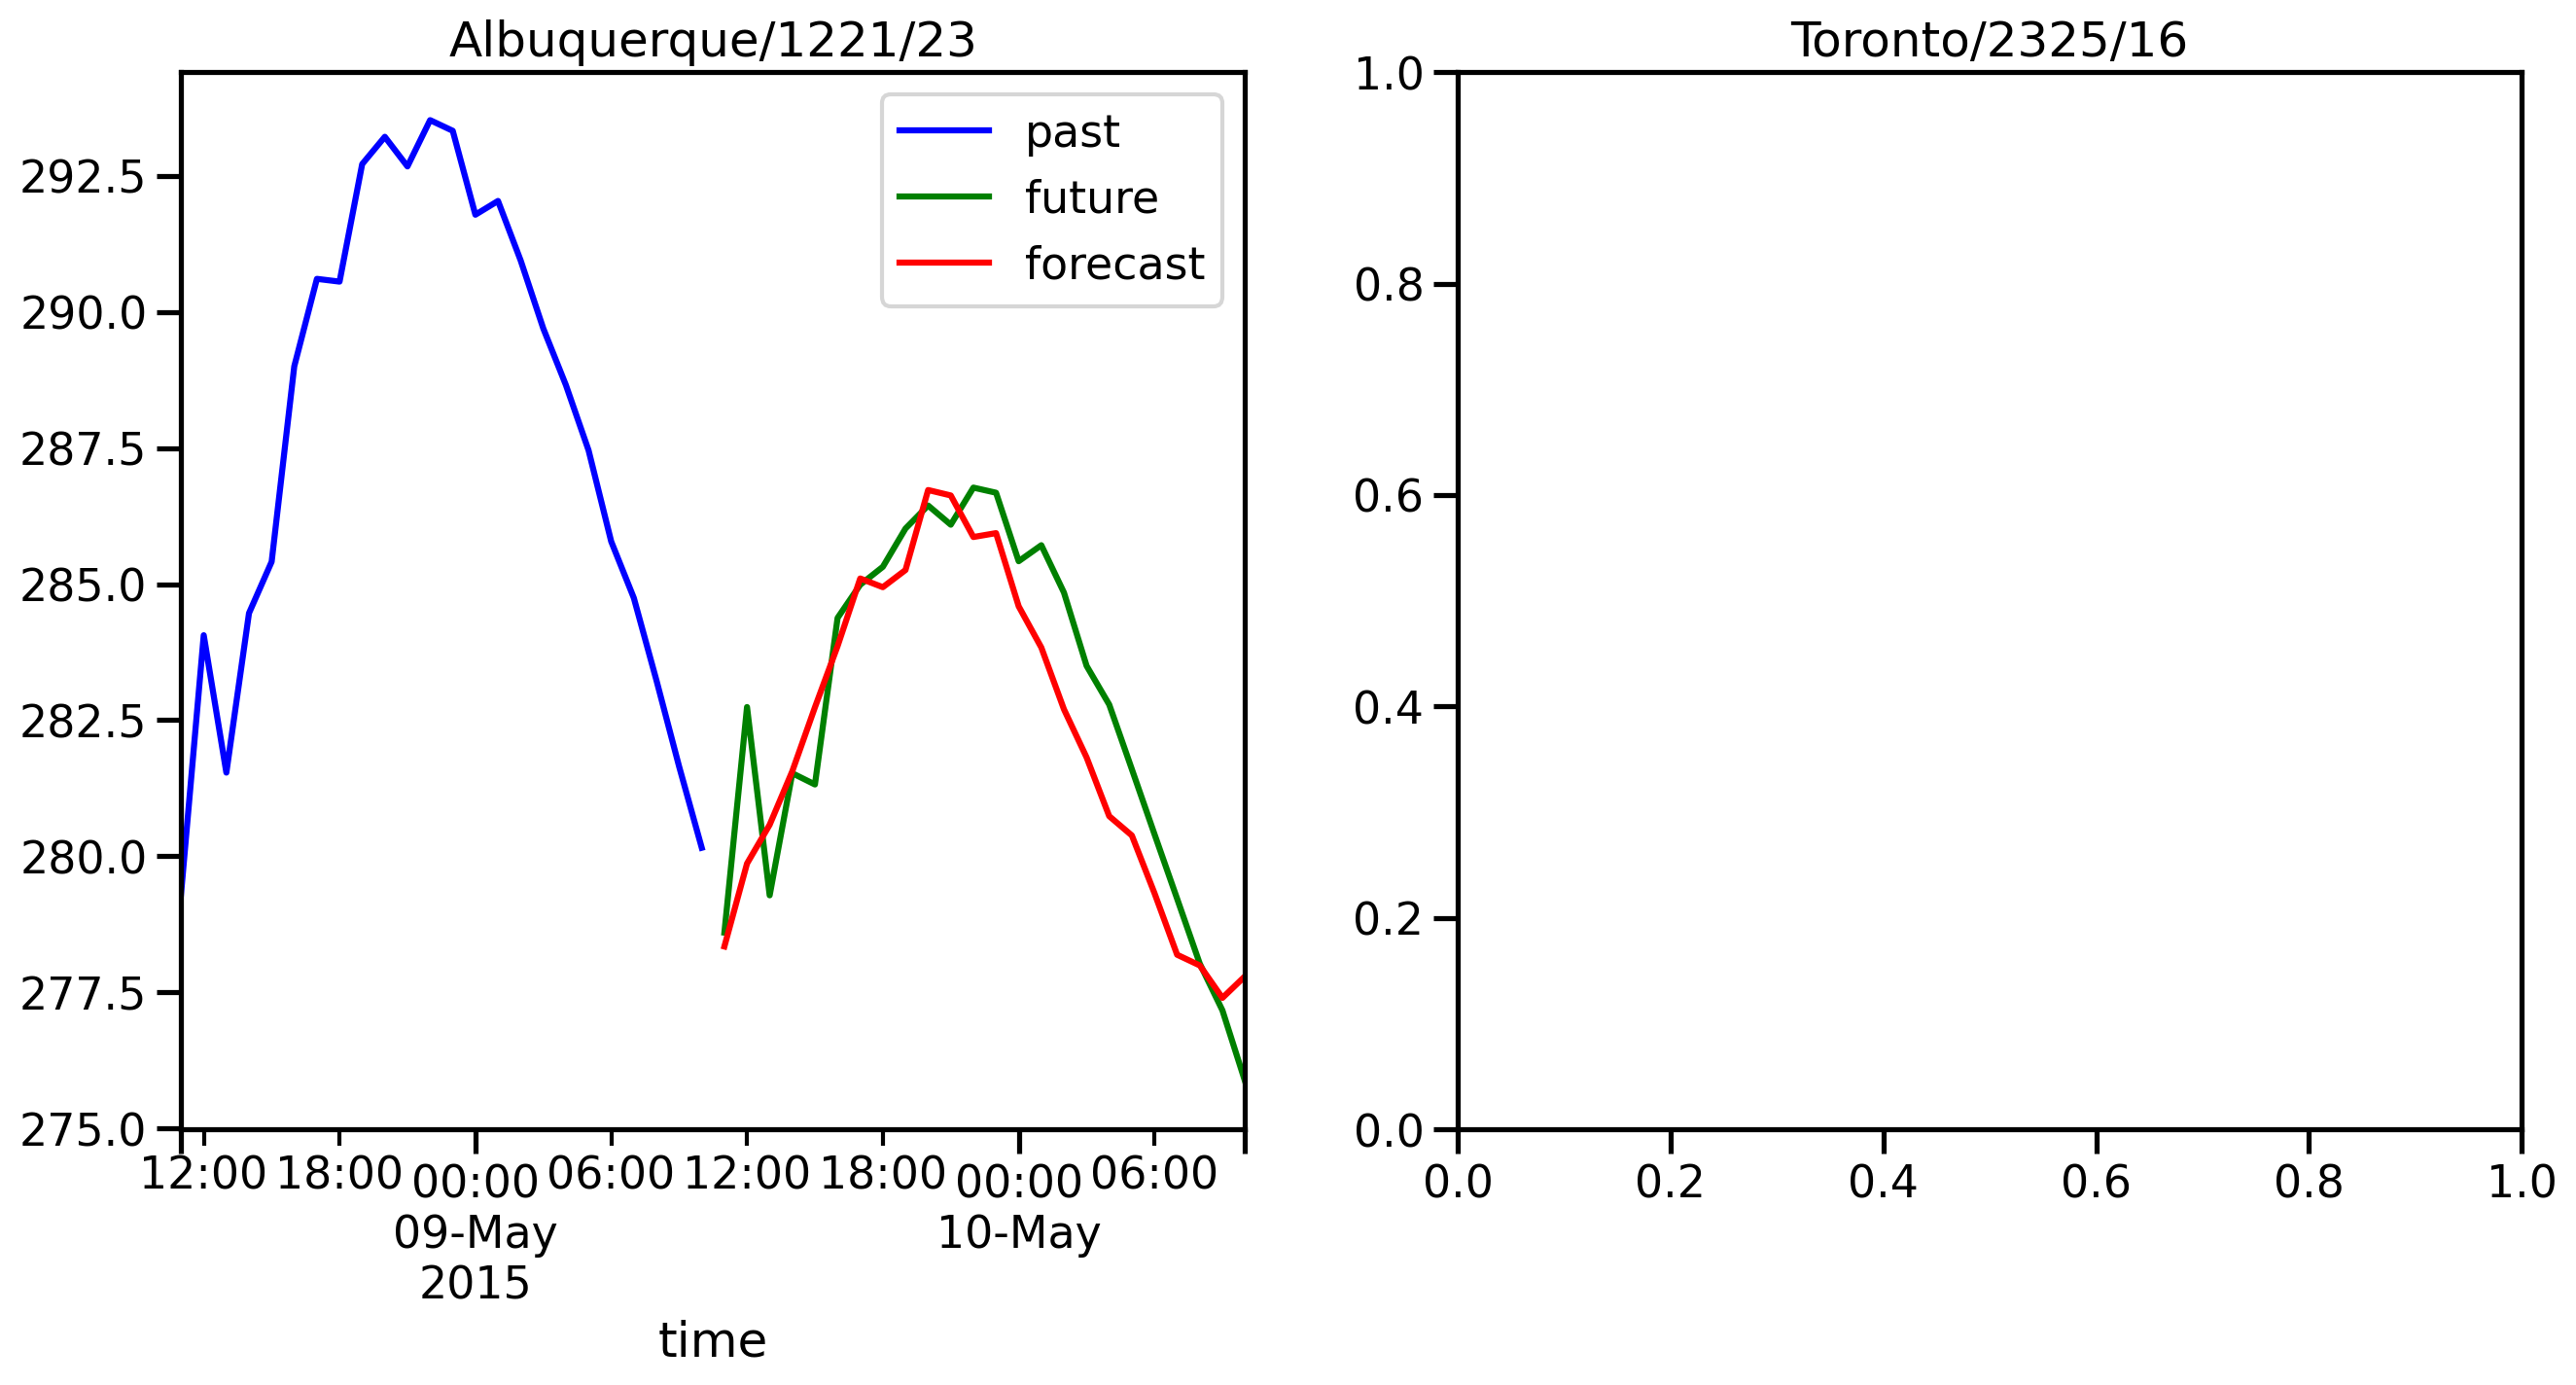

In [98]:
from utils import nd_target_like_panel, plot_random_forecasts

# Generate predictions on the test dataset
test_y_hat = nd_target_like_panel(test_y, model.predict(test_X_nd))

# Plot random forecasts to compare actual vs. predicted temperatures
plot_random_forecasts(
    test_X['temperature'],   # Input feature data for plotting context
    test_y['temperature'],   # Actual temperature from the test set
    test_y_hat.rename(columns={'temperature': 'forecast'})  # Predicted temperatures
)

In [ ]:
# TODO: save your predictions on the Score segment as a Pandas data frame
# into a variable named score_y_hat.
import numpy as np
import pandas as pd
import os
import json

# Keras model will output an array of shape (2399, 24) for the Score segment,
# however the expected shape of the submitted data frame is (57576, 1).
# 57576 = 2399 (count of samples in Score segment) x 24 (prediction window).
score_predictions = model.predict(score_X_nd)

# Reshape the predictions from shape (2399, 24) to (57576, 1)
# Using ravel to flatten the array into the correct format
score_y_hat = pd.DataFrame(score_predictions.ravel(), columns=['temperature'])

# Check the shape and column name of the prediction DataFrame
print(score_y_hat.columns, score_y_hat.shape)  # Expected: (Index(['temperature'], dtype='object'), (57576, 1))


(Index([], dtype='object'), (0, 0))

In [38]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. temperature forecast for the Score segment

import os
model_dir = 'weathernet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.weights.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')